In [1]:
# Import necessary libraries
import os
import cv2
import glob
import PIL
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import data
from skimage.util import montage
import skimage.transform as skTrans
from skimage.transform import rotate, resize
from PIL import Image, ImageOps

# Neural imaging
import nilearn as nl
import nibabel as nib
import nilearn.plotting as nlplt

# ML libraries
import keras
# import keras.backend as K
# from tensorflow.keras.layers as K

from keras.callbacks import CSVLogger
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard

# Make numpy printouts easier to read
np.set_printoptions(precision=3, suppress=True)


In [2]:
# DEFINE seg-areas  
SEGMENT_CLASSES = {
    0 : 'NOT tumor',   
    1 : 'NECROTIC/CORE', # or NON-ENHANCING tumor CORE - RED
    2 : 'EDEMA',  # Green
    3 : 'ENHANCING' # original 4 -> converted into 3 later, Yellow
}

# there are 155 slices per volume
# to start at 5 and use 145 slices means we will skip the first 5 and last 5 
VOLUME_SLICES = 80 
VOLUME_START_AT = 60 # first slice of volume that we will include

IMG_SIZE=128

In [3]:
# Copy and rename the file to .zip, then extract it into a folder named processed_data
!cp /kaggle/input/brats2023roi-full/brats2023roi/processed_data.whatever /kaggle/working/processed_data.zip && \
unzip /kaggle/working/processed_data.zip -d /kaggle/working/

/usr/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Archive:  /kaggle/working/processed_data.zip
   creating: /kaggle/working/processed_data/
   creating: /kaggle/working/processed_data/BraTS-GLI-00000-000/
  inflating: /kaggle/working/processed_data/BraTS-GLI-00000-000/BraTS-GLI-00000-000-seg.nii.gz  
  inflating: /kaggle/working/processed_data/BraTS-GLI-00000-000/BraTS-GLI-00000-000-t1c.nii.gz  
  inflating: /kaggle/working/processed_data/BraTS-GLI-00000-000/BraTS-GLI-00000-000-t1n.nii.gz  
  inflating: /kaggle/working/processed_data/BraTS-GLI-00000-000/BraTS-GLI-00000-000-t2f.nii.gz  
  inflating: /kaggle/working/processed_data/BraTS-GLI-00000-000/BraTS-GLI-00000-000-t2w.nii.gz  
   creating: /kaggle/working/processed_data/BraTS-GLI-00002-000/
  inflating: /kaggle/working/processed_data/BraTS-GLI-00002-000/BraTS-GLI-00002-000-seg.nii.gz  
  inflating: /kaggle/working/processed_data/BraTS-GLI-00002-000/BraTS-GLI-00002-000-t1c.nii.gz  
  inflating: /kaggle/working/processed_data/BraTS-GLI-00002-000/BraTS-GLI-00002-000-t1n.nii.gz  
  in

In [4]:
# this just removes the zip to save space
!rm /kaggle/working/processed_data.zip

In [5]:
# Define the base directory
base_dir = '/kaggle/working/processed_data/'

# Walk through all subdirectories in the base directory
for folder in os.listdir(base_dir):
    folder_path = os.path.join(base_dir, folder)
    
    # Check if it's a directory
    if os.path.isdir(folder_path):
        # Check if 't2f.nii.gz' exists in the folder
        t2f_file = os.path.join(folder_path, f'{folder}-t2f.nii.gz')
        
        if not os.path.isfile(t2f_file):
            # If 't2f.nii.gz' is missing, delete the entire folder
            shutil.rmtree(folder_path)
            print(f"Deleted {folder_path} as it doesn't contain 't2f.nii.gz'")
        else:
            print(f"'{folder}' contains 't2f.nii.gz'.")

'BraTS-GLI-00739-000' contains 't2f.nii.gz'.
'BraTS-GLI-01339-000' contains 't2f.nii.gz'.
'BraTS-GLI-01289-000' contains 't2f.nii.gz'.
'BraTS-GLI-00518-001' contains 't2f.nii.gz'.
'BraTS-GLI-00561-000' contains 't2f.nii.gz'.
'BraTS-GLI-00008-000' contains 't2f.nii.gz'.
'BraTS-GLI-00683-000' contains 't2f.nii.gz'.
'BraTS-GLI-00151-000' contains 't2f.nii.gz'.
Deleted /kaggle/working/processed_data/BraTS-GLI-01025-000 as it doesn't contain 't2f.nii.gz'
'BraTS-GLI-01280-000' contains 't2f.nii.gz'.
'BraTS-GLI-01002-000' contains 't2f.nii.gz'.
'BraTS-GLI-00154-000' contains 't2f.nii.gz'.
'BraTS-GLI-01457-000' contains 't2f.nii.gz'.
'BraTS-GLI-01330-000' contains 't2f.nii.gz'.
'BraTS-GLI-00698-000' contains 't2f.nii.gz'.
Deleted /kaggle/working/processed_data/BraTS-GLI-00296-000 as it doesn't contain 't2f.nii.gz'
'BraTS-GLI-01323-000' contains 't2f.nii.gz'.
'BraTS-GLI-01187-000' contains 't2f.nii.gz'.
'BraTS-GLI-01059-000' contains 't2f.nii.gz'.
'BraTS-GLI-01438-000' contains 't2f.nii.gz'.
'B

In [6]:
import tensorflow as tf

# Dice coefficient for 4 classes
def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 4
    total_loss = 0
    for i in range(class_num):
        y_true_f = tf.reshape(y_true[:,:,:,i], [-1])
        y_pred_f = tf.reshape(y_pred[:,:,:,i], [-1])
        intersection = tf.reduce_sum(y_true_f * y_pred_f)
        loss = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
        total_loss += loss
            
    return total_loss / class_num

# Dice coefficient per class
def dice_coef_necrotic(y_true, y_pred, epsilon=1e-6):
    intersection = tf.reduce_sum(tf.abs(y_true[:,:,:,1] * y_pred[:,:,:,1]))
    return (2. * intersection) / (tf.reduce_sum(tf.square(y_true[:,:,:,1])) + tf.reduce_sum(tf.square(y_pred[:,:,:,1])) + epsilon)

def dice_coef_edema(y_true, y_pred, epsilon=1e-6):
    intersection = tf.reduce_sum(tf.abs(y_true[:,:,:,2] * y_pred[:,:,:,2]))
    return (2. * intersection) / (tf.reduce_sum(tf.square(y_true[:,:,:,2])) + tf.reduce_sum(tf.square(y_pred[:,:,:,2])) + epsilon)

def dice_coef_enhancing(y_true, y_pred, epsilon=1e-6):
    intersection = tf.reduce_sum(tf.abs(y_true[:,:,:,3] * y_pred[:,:,:,3]))
    return (2. * intersection) / (tf.reduce_sum(tf.square(y_true[:,:,:,3])) + tf.reduce_sum(tf.square(y_pred[:,:,:,3])) + epsilon)

# Precision
def precision(y_true, y_pred):
    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true * y_pred, 0, 1)))
    predicted_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_pred, 0, 1)))
    return true_positives / (predicted_positives + tf.keras.backend.epsilon())

# Sensitivity (Recall)
def sensitivity(y_true, y_pred):
    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true * y_pred, 0, 1)))
    possible_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true, 0, 1)))
    return true_positives / (possible_positives + tf.keras.backend.epsilon())

# Specificity
def specificity(y_true, y_pred):
    true_negatives = tf.reduce_sum(tf.round(tf.clip_by_value((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = tf.reduce_sum(tf.round(tf.clip_by_value(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + tf.keras.backend.epsilon())


**Modified SANet Model Arch.**

1. Batch normalization throughout the network
2. Residual connections within conv blocks
3. Feature Pyramid Network (FPN)
4. Channel Attention alongside spatial attention


In [7]:
import tensorflow as tf
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, UpSampling2D, Dropout, Input, 
    concatenate, BatchNormalization, GlobalAveragePooling2D, 
    GlobalMaxPooling2D, Reshape, Add, Multiply
)
from tensorflow.keras.models import Model

def enhanced_conv_block(x, filters, ker_init, dropout):
    shortcut = x
    
    # Match channels for residual if needed
    if shortcut.shape[-1] != filters:
        shortcut = Conv2D(filters, 1, padding='same', kernel_initializer=ker_init)(shortcut)
    
    # Main path
    x = Conv2D(filters, 3, padding='same', kernel_initializer=ker_init)(x)
    x = BatchNormalization()(x)
    x = tf.keras.activations.relu(x)
    
    x = Conv2D(filters, 3, padding='same', kernel_initializer=ker_init)(x)
    x = BatchNormalization()(x)
    x = tf.keras.activations.relu(x)
    
    # Residual connection
    x = Add()([x, shortcut])
    x = tf.keras.activations.relu(x)
    
    return Dropout(dropout)(x)

def enhanced_attention_block(x, g, inter_channels):
    # Channel attention
    avg_pool = GlobalAveragePooling2D()(x)
    max_pool = GlobalMaxPooling2D()(x)
    
    avg_pool = Reshape((1, 1, inter_channels))(avg_pool)
    max_pool = Reshape((1, 1, inter_channels))(max_pool)
    
    channel_att = Add()([avg_pool, max_pool])
    channel_att = Conv2D(inter_channels, 1)(channel_att)
    channel_att = tf.keras.activations.sigmoid(channel_att)
    
    # Spatial attention with gating signal
    theta_x = Conv2D(inter_channels, 1, strides=1, padding='same')(x)
    phi_g = Conv2D(inter_channels, 1, strides=1, padding='same')(g)
    f = Add()([theta_x, phi_g])
    
    # Refined spatial attention
    f = Conv2D(inter_channels, 1, padding='same')(f)
    f = BatchNormalization()(f)
    f = tf.keras.activations.relu(f)
    spatial_att = Conv2D(1, 1, padding='same')(f)
    spatial_att = tf.keras.activations.sigmoid(spatial_att)
    
    # Apply both attention mechanisms
    x = Multiply()([x, channel_att])
    x = Multiply()([x, spatial_att])
    
    return x

def build_sanet(inputs, ker_init, dropout):
    # Encoder path with enhanced conv blocks
    conv1 = enhanced_conv_block(inputs, 32, ker_init, dropout)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = enhanced_conv_block(pool1, 64, ker_init, dropout)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = enhanced_conv_block(pool2, 128, ker_init, dropout)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = enhanced_conv_block(pool3, 256, ker_init, dropout)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    
    # Bridge
    conv5 = enhanced_conv_block(pool4, 512, ker_init, dropout)
    
    # Decoder path with enhanced attention
    up6 = UpSampling2D(size=(2, 2))(conv5)
    att6 = enhanced_attention_block(conv4, up6, 256)
    merge6 = concatenate([up6, att6])
    conv6 = enhanced_conv_block(merge6, 256, ker_init, dropout)
    
    up7 = UpSampling2D(size=(2, 2))(conv6)
    att7 = enhanced_attention_block(conv3, up7, 128)
    merge7 = concatenate([up7, att7])
    conv7 = enhanced_conv_block(merge7, 128, ker_init, dropout)
    
    up8 = UpSampling2D(size=(2, 2))(conv7)
    att8 = enhanced_attention_block(conv2, up8, 64)
    merge8 = concatenate([up8, att8])
    conv8 = enhanced_conv_block(merge8, 64, ker_init, dropout)
    
    up9 = UpSampling2D(size=(2, 2))(conv8)
    att9 = enhanced_attention_block(conv1, up9, 32)
    merge9 = concatenate([up9, att9])
    conv9 = enhanced_conv_block(merge9, 32, ker_init, dropout)
    
    # Output layer
    outputs = Conv2D(4, (1, 1), activation='softmax')(conv9)
    
    return Model(inputs=inputs, outputs=outputs)

# Define input layer
IMG_SIZE = 128
input_layer = Input((IMG_SIZE, IMG_SIZE, 2))

# Build and compile the enhanced SA-Net model
model = build_sanet(input_layer, 'he_normal', 0.2)
model.compile(loss="categorical_crossentropy", 
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
              metrics=['accuracy', 
                       tf.keras.metrics.MeanIoU(num_classes=4), 
                       dice_coef, precision, 
                       sensitivity, specificity, 
                       dice_coef_necrotic, 
                       dice_coef_edema, 
                       dice_coef_enhancing])

# Print model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 2)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 32)   │            608 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 128, 128, 32)   │            128 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 128, 128, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 32)   │          9,248 │ re_lu[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 128, 128, 32)   │            128 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_1 (ReLU)            │ (None, 128, 128, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 32)   │             96 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 128, 128, 32)   │              0 │ re_lu_1[0][0],         │
│                           │                        │                │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_2 (ReLU)            │ (None, 128, 128, 32)   │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 128, 128, 32)   │              0 │ re_lu_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 64, 64, 32)     │              0 │ dropout[0][0]          │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 64)     │         18,496 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 64, 64, 64)     │            256 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_3 (ReLU)            │ (None, 64, 64, 64)     │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 64)     │         36,928 │ re_lu_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 64, 64, 64)     │            256 │ conv2d_5[0][0]         │
│ (BatchNormalization) 

 Total params: 8,734,504 (33.32 MB)

 Trainable params: 8,727,656 (33.29 MB)

 Non-trainable params: 6,848 (26.75 KB)

In [8]:
# lists of directories with studies
TRAIN_DATASET_PATH = "/kaggle/working/processed_data"
train_and_val_directories = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]


def pathListIntoIds(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x

train_and_test_ids = pathListIntoIds(train_and_val_directories); 

    
train_test_ids, val_ids = train_test_split(train_and_test_ids,test_size=0.2) 
train_ids, test_ids = train_test_split(train_test_ids,test_size=0.15) 

In [9]:
import tensorflow as tf
import numpy as np
import os
import nibabel as nib
import cv2

class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, dim=(IMG_SIZE, IMG_SIZE), batch_size=1, n_channels=2, shuffle=True, **kwargs):
        'Initialization'
        super().__init__(**kwargs)
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.list_IDs) / self.batch_size))  # Use np.ceil to round up

    def __iter__(self):
        while True:
            if self.shuffle:
                self.on_epoch_end()
            for index in range(len(self)):
                yield self.__getitem__(index)

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size: (index + 1) * self.batch_size]
        Batch_ids = [self.list_IDs[k] for k in indexes]
        X, y = self.__data_generation(Batch_ids)
        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def load_image_data(self, case_path, img_type):
        data_path = os.path.join(case_path, f'{img_type}.nii.gz')
        try:
            return nib.load(data_path).get_fdata()
        except (FileNotFoundError, nib.filebasedimages.ImageFileError):
            # print(f"Error loading file: {data_path}. Skipping...")
            return None

    def resize_image(self, image, target_size):
        return cv2.resize(image, target_size)

    def zscore_normalize(self, image):
        'Z-score normalization'
        mean = np.mean(image)
        std = np.std(image)
        return (image - mean) / std if std > 0 else image

    def preprocess_image(self, flair, ce):
        flair_normalized = self.zscore_normalize(flair)
        ce_normalized = self.zscore_normalize(ce)

        return flair_normalized, ce_normalized

    def preprocess_segmentation(self, seg):
        'Ensure segmentation values are in the range [0, num_classes - 1]'
        seg = seg.astype(np.uint8)
        seg[seg == 4] = 3  # Adjust tumor labels if necessary
        return seg

    def generate_mask(self, seg):
        mask = tf.one_hot(seg, 4)
        resized_mask = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE))
        return resized_mask

    def __data_generation(self, Batch_ids):
        X = np.zeros((self.batch_size * VOLUME_SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size * VOLUME_SLICES, 240, 240))
        Y = np.zeros((self.batch_size * VOLUME_SLICES, *self.dim, 4))

        for c, i in enumerate(Batch_ids):
            case_path = os.path.join(TRAIN_DATASET_PATH, i)
            flair = self.load_image_data(case_path, f'{i}-t2f')
            ce = self.load_image_data(case_path, f'{i}-t1c')
            seg = self.load_image_data(case_path, f'{i}-seg')

            if flair is None or ce is None or seg is None:
                # print(f"Skipping case {i} due to missing or invalid files.")
                continue

            try:
                seg = self.preprocess_segmentation(seg)
            except Exception as e:
                # print(f"Error preprocessing segmentation for case {i}: {e}")
                continue

            for j in range(VOLUME_SLICES):
                try:
                    flair_slice = self.resize_image(flair[:, :, j + VOLUME_START_AT], self.dim)
                    ce_slice = self.resize_image(ce[:, :, j + VOLUME_START_AT], self.dim)
                    flair_slice, ce_slice = self.preprocess_image(flair_slice, ce_slice)

                    X[j + VOLUME_SLICES * c, :, :, 0] = flair_slice
                    X[j + VOLUME_SLICES * c, :, :, 1] = ce_slice
                    y[j + VOLUME_SLICES * c] = seg[:, :, j + VOLUME_START_AT]
                except Exception as e:
                    # print(f"Error processing slice {j} for case {i}: {e}")
                    continue

        Y = self.generate_mask(y)
        return X, Y


# Example usage
training_generator = DataGenerator(train_ids)
valid_generator = DataGenerator(val_ids)
test_generator = DataGenerator(test_ids)

In [10]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau

# Define callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_dice_coef',
        patience=25,  # Increased patience
        restore_best_weights=True,
        mode='max',
        min_delta=1e-4
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_dice_coef',
        factor=0.5,  # Gentler reduction
        patience=10,
        min_lr=1e-6,
        mode='max',
        verbose=1
    ),
    tf.keras.callbacks.ModelCheckpoint(
        'best_model_{epoch:02d}_{val_dice_coef:.4f}.keras',
        monitor='val_dice_coef',
        mode='max',
        save_best_only=True,
        verbose=1
    )
]

# Create directories if they don't exist
import os
os.makedirs('models', exist_ok=True)
os.makedirs('logs', exist_ok=True)

# Train the model
history = model.fit(
    training_generator,
    epochs=40,  # Increased max epochs
    callbacks=callbacks,
    validation_data=valid_generator,
    shuffle=True
)

Epoch 1/40
746/746 ━━━━━━━━━━━━━━━━━━━━ 0s 836ms/step - accuracy: 0.9632 - dice_coef: 0.3765 - dice_coef_edema: 0.4760 - dice_coef_enhancing: 0.2142 - dice_coef_necrotic: 0.1555 - loss: 0.2512 - mean_io_u: 0.4849 - precision: 0.9675 - sensitivity: 0.9582 - specificity: 0.9899
Epoch 1: val_dice_coef improved from -inf to 0.48828, saving model to best_model_01_0.4883.keras
746/746 ━━━━━━━━━━━━━━━━━━━━ 883s 1s/step - accuracy: 0.9632 - dice_coef: 0.3765 - dice_coef_edema: 0.4762 - dice_coef_enhancing: 0.2145 - dice_coef_necrotic: 0.1556 - loss: 0.2510 - mean_io_u: 0.4849 - precision: 0.9675 - sensitivity: 0.9582 - specificity: 0.9899 - val_accuracy: 0.9881 - val_dice_coef: 0.4883 - val_dice_coef_edema: 0.6846 - val_dice_coef_enhancing: 0.3738 - val_dice_coef_necrotic: 0.1974 - val_loss: 0.0401 - val_mean_io_u: 0.4998 - val_precision: 0.9884 - val_sensitivity: 0.9872 - val_specificity: 0.9961 - learning_rate: 0.0010
Epoch 2/40
746/746 ━━━━━━━━━━━━━━━━━━━━ 0s 841ms/step - accuracy: 0.9903 -

132/132 ━━━━━━━━━━━━━━━━━━━━ 112s 844ms/step - accuracy: 0.9948 - dice_coef: 0.7454 - dice_coef_edema: 0.8190 - dice_coef_enhancing: 0.8102 - dice_coef_necrotic: 0.7255 - loss: 0.0171 - mean_io_u: 0.5589 - precision: 0.9944 - sensitivity: 0.9937 - specificity: 0.9981
Evaluation Results:
Loss: 0.0186
Accuracy: 0.9946
Mean IoU: 0.5000
Dice Coefficient: 0.7398
Precision: 0.9942
Sensitivity (Recall): 0.9936
Specificity: 0.9981
Dice Coef - Necrotic: 0.7078
Dice Coef - Edema: 0.8194
Dice Coef - Enhancing: 0.8036


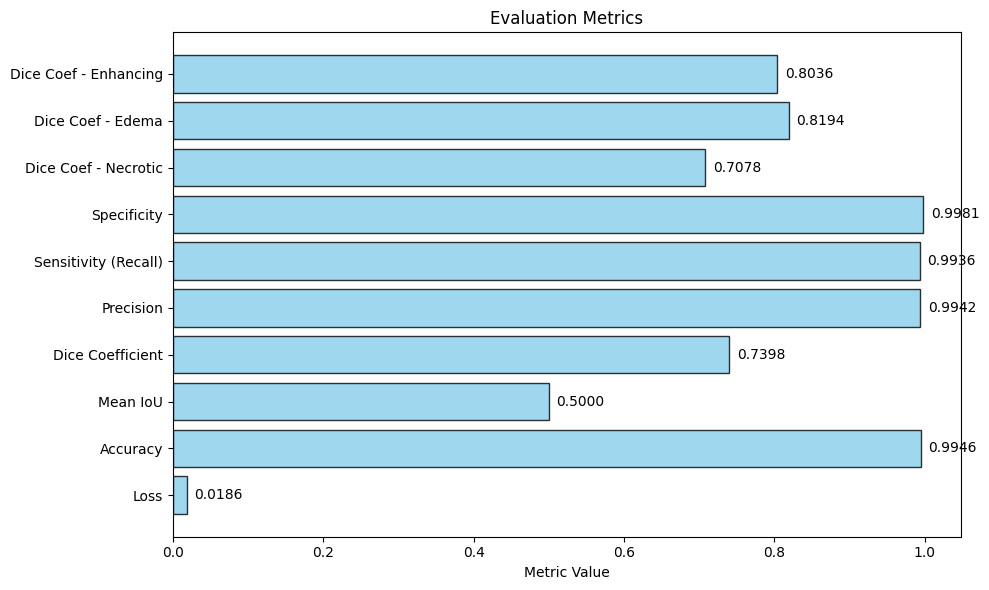

In [11]:
test_metrics = model.evaluate(test_generator, verbose=1)

# Metrics names corresponding to the evaluation metrics
metrics_names = [
    "Loss", "Accuracy", "Mean IoU", "Dice Coefficient",
    "Precision", "Sensitivity (Recall)", "Specificity",
    "Dice Coef - Necrotic", "Dice Coef - Edema", "Dice Coef - Enhancing"
]

# Print the evaluation results
print("Evaluation Results:")
for name, value in zip(metrics_names, test_metrics):
    print(f"{name}: {value:.4f}")

# Visualization: Bar Chart of Evaluation Metrics
def plot_evaluation_bar_chart(metrics_names, metrics_values):
    plt.figure(figsize=(10, 6))
    y_pos = np.arange(len(metrics_names))

    plt.barh(y_pos, metrics_values, alpha=0.8, color='skyblue', edgecolor='black')
    plt.yticks(y_pos, metrics_names)
    plt.xlabel("Metric Value")
    plt.title("Evaluation Metrics")
    
    # Adding value labels
    for i, v in enumerate(metrics_values):
        plt.text(v + 0.01, i, f"{v:.4f}", va='center', fontsize=10)

    plt.tight_layout()
    plt.show()

# Plot the metrics
plot_evaluation_bar_chart(metrics_names, test_metrics)

In [12]:
import pickle

# Save the history object using pickle
with open('ModifiedSANet_model.pkl', 'wb') as f:
    pickle.dump(history.history, f)

print("ModifiedSANet_history saved successfully.")

ModifiedSANet_history saved successfully.


In [13]:
# Load the history object
with open('ModifiedSANet_model.pkl', 'rb') as f:
    loaded_history = pickle.load(f)

print("ModifiedSANet_history loaded successfully.")

ModifiedSANet_history loaded successfully.


In [14]:
loaded_history.keys()

dict_keys(['accuracy', 'dice_coef', 'dice_coef_edema', 'dice_coef_enhancing', 'dice_coef_necrotic', 'loss', 'mean_io_u', 'precision', 'sensitivity', 'specificity', 'val_accuracy', 'val_dice_coef', 'val_dice_coef_edema', 'val_dice_coef_enhancing', 'val_dice_coef_necrotic', 'val_loss', 'val_mean_io_u', 'val_precision', 'val_sensitivity', 'val_specificity', 'learning_rate'])

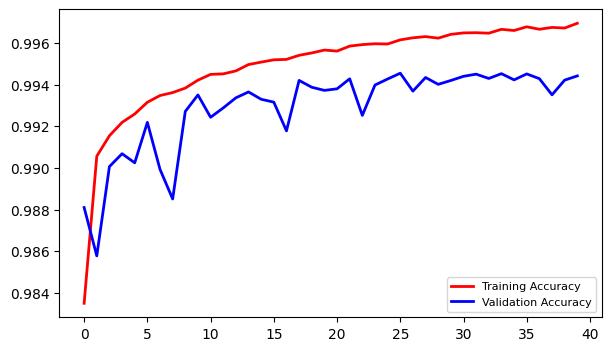

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

acc = loaded_history['accuracy']
val_acc = loaded_history['val_accuracy']
epochs = range(len(acc))

fig = plt.figure(figsize=(7,4))

# Set the linewidth to a smaller value (e.g., 2)
plt.plot(epochs, acc, 'r', label="Training Accuracy", linewidth=2)
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy", linewidth=2)

# Adjust the legend font size
plt.legend(loc='lower right', fontsize=8)  # Set fontsize to your preference

plt.show()

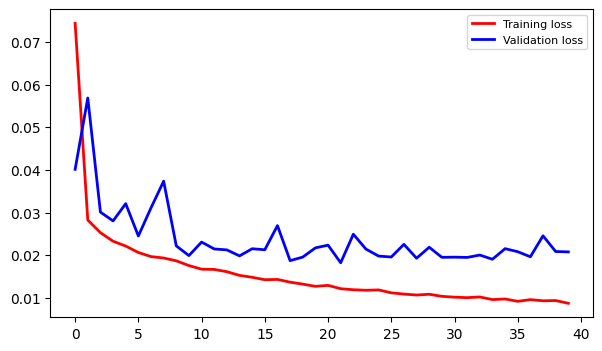

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

loss = loaded_history['loss']
val_loss = loaded_history['val_loss']
epochs = range(len(loss))

fig = plt.figure(figsize=(7,4))

# Set the linewidth to a smaller value (e.g., 2)
plt.plot(epochs, loss, 'r', label="Training loss", linewidth=2)
plt.plot(epochs, val_loss, 'b', label="Validation loss", linewidth=2)

# Adjust the legend font size
plt.legend(loc='upper right', fontsize=8)  # Set fontsize to your preference

plt.show()

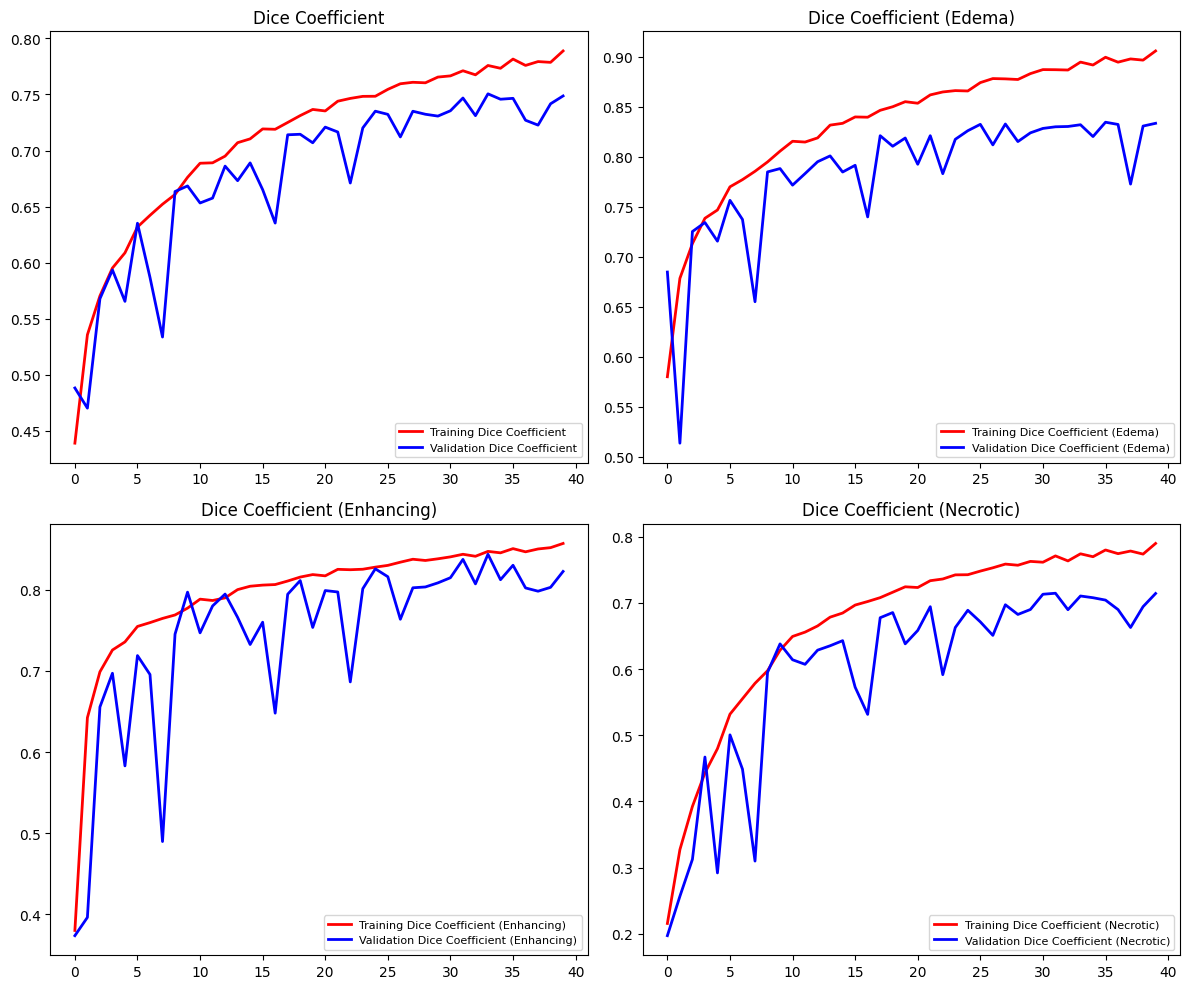

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract the required metrics from the history dictionary
dice_coef = loaded_history['dice_coef']
val_dice_coef = loaded_history['val_dice_coef']
dice_coef_edema = loaded_history['dice_coef_edema']
val_dice_coef_edema = loaded_history['val_dice_coef_edema']
dice_coef_enhancing = loaded_history['dice_coef_enhancing']
val_dice_coef_enhancing = loaded_history['val_dice_coef_enhancing']
dice_coef_necrotic = loaded_history['dice_coef_necrotic']
val_dice_coef_necrotic = loaded_history['val_dice_coef_necrotic']

epochs = range(len(dice_coef))  # assuming all metrics have the same length

# Set up the figure
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Plot for dice_coef
axs[0, 0].plot(epochs, dice_coef, 'r', label="Training Dice Coefficient", linewidth=2)
axs[0, 0].plot(epochs, val_dice_coef, 'b', label="Validation Dice Coefficient", linewidth=2)
axs[0, 0].set_title("Dice Coefficient")
#axs[0, 0].set_ylim(0, 2) 
axs[0, 0].legend(loc='lower right', fontsize=8)

# Plot for dice_coef_edema
axs[0, 1].plot(epochs, dice_coef_edema, 'r', label="Training Dice Coefficient (Edema)", linewidth=2)
axs[0, 1].plot(epochs, val_dice_coef_edema, 'b', label="Validation Dice Coefficient (Edema)", linewidth=2)
axs[0, 1].set_title("Dice Coefficient (Edema)")
#axs[0, 1].set_ylim(0, 2) 
axs[0, 1].legend(loc='lower right', fontsize=8)

# Plot for dice_coef_enhancing
axs[1, 0].plot(epochs, dice_coef_enhancing, 'r', label="Training Dice Coefficient (Enhancing)", linewidth=2)
axs[1, 0].plot(epochs, val_dice_coef_enhancing, 'b', label="Validation Dice Coefficient (Enhancing)", linewidth=2)
axs[1, 0].set_title("Dice Coefficient (Enhancing)")
#axs[1, 0].set_ylim(0, 2) 
axs[1, 0].legend(loc='lower right', fontsize=8)

# Plot for dice_coef_necrotic
axs[1, 1].plot(epochs, dice_coef_necrotic, 'r', label="Training Dice Coefficient (Necrotic)", linewidth=2)
axs[1, 1].plot(epochs, val_dice_coef_necrotic, 'b', label="Validation Dice Coefficient (Necrotic)", linewidth=2)
axs[1, 1].set_title("Dice Coefficient (Necrotic)")
#axs[1, 1].set_ylim(0, 2) 
axs[1, 1].legend(loc='lower right', fontsize=8)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


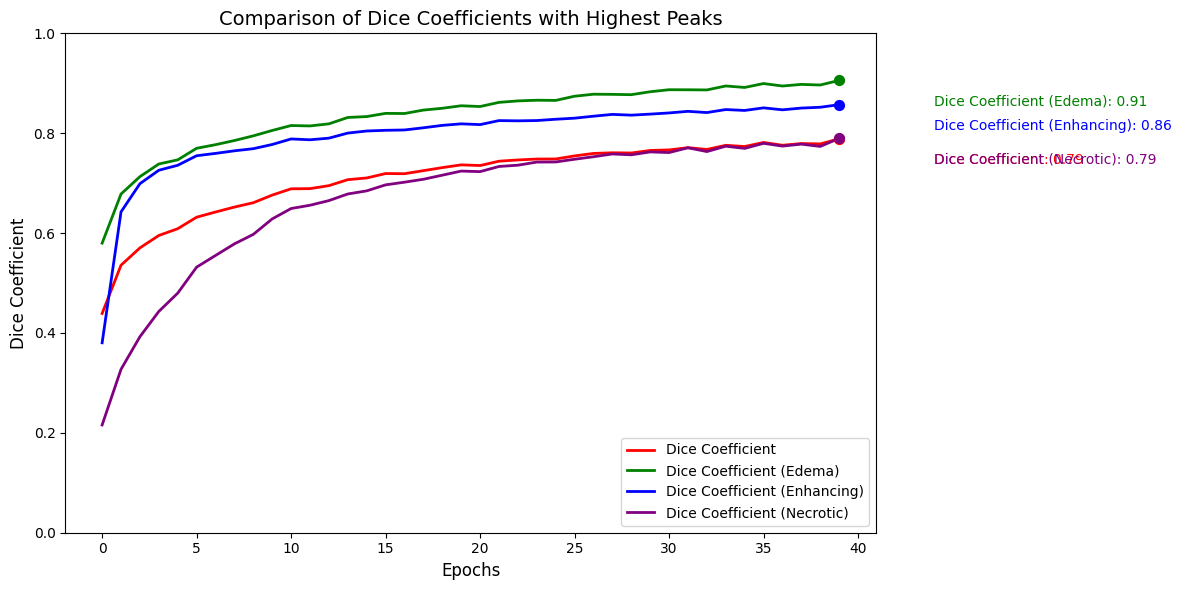

In [18]:
import matplotlib.pyplot as plt

# Extract metrics from the history dictionary (training values only)
dice_coef = loaded_history['dice_coef']
dice_coef_edema = loaded_history['dice_coef_edema']
dice_coef_enhancing = loaded_history['dice_coef_enhancing']
dice_coef_necrotic = loaded_history['dice_coef_necrotic']

epochs = range(len(dice_coef))  # assuming all metrics have the same length

# Set up the figure
plt.figure(figsize=(12, 6))

# Plot all dice coefficients with their respective colors
plt.plot(epochs, dice_coef, label="Dice Coefficient", linewidth=2, color='red')
plt.plot(epochs, dice_coef_edema, label="Dice Coefficient (Edema)", linewidth=2, color='green')
plt.plot(epochs, dice_coef_enhancing, label="Dice Coefficient (Enhancing)", linewidth=2, color='blue')
plt.plot(epochs, dice_coef_necrotic, label="Dice Coefficient (Necrotic)", linewidth=2, color='purple')

# Annotate the highest peak for each metric with a filled color ball
def annotate_peak_with_ball(metric, color, label):
    peak_value = max(metric)
    peak_epoch = metric.index(peak_value)
    plt.scatter(peak_epoch, peak_value, color=color, s=50, zorder=5)  # Plot color-filled ball
    plt.text(peak_epoch + 5, peak_value - 0.05, f'{label}: {peak_value:.2f}', fontsize=10, color=color)

# Annotating each metric's highest peak with a color-filled ball
annotate_peak_with_ball(dice_coef, 'red', "Dice Coefficient")
annotate_peak_with_ball(dice_coef_edema, 'green', "Dice Coefficient (Edema)")
annotate_peak_with_ball(dice_coef_enhancing, 'blue', "Dice Coefficient (Enhancing)")
annotate_peak_with_ball(dice_coef_necrotic, 'purple', "Dice Coefficient (Necrotic)")

# Add titles and labels
plt.title("Comparison of Dice Coefficients with Highest Peaks", fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Dice Coefficient', fontsize=12)

# Adjust the y-axis range to be from 0 to 1
plt.ylim(0, 1)

# Display legend
plt.legend(loc='lower right', fontsize=10)

# Show the plot
plt.tight_layout()
plt.show()


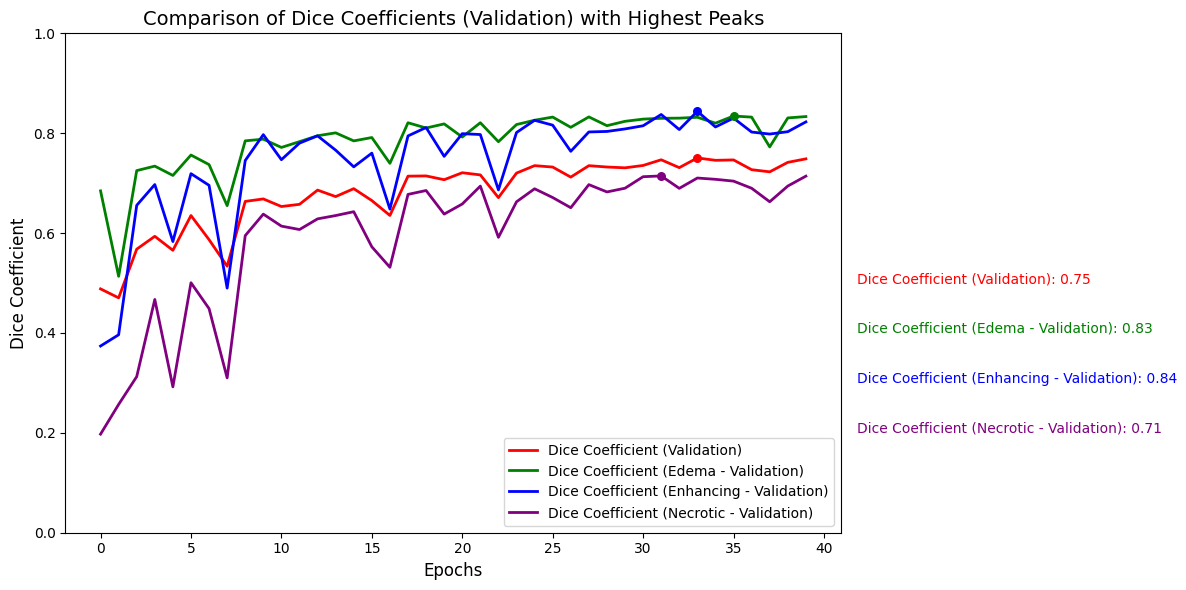

In [19]:
import matplotlib.pyplot as plt

# Extract validation metrics from the history dictionary
val_dice_coef = loaded_history['val_dice_coef']
val_dice_coef_edema = loaded_history['val_dice_coef_edema']
val_dice_coef_enhancing = loaded_history['val_dice_coef_enhancing']
val_dice_coef_necrotic = loaded_history['val_dice_coef_necrotic']

epochs = range(len(val_dice_coef))  # assuming all metrics have the same length

# Set up the figure
plt.figure(figsize=(12, 6))

# Plot only validation dice coefficients
line_width = 2
plt.plot(epochs, val_dice_coef, label="Dice Coefficient (Validation)", linewidth=line_width, color='red')
plt.plot(epochs, val_dice_coef_edema, label="Dice Coefficient (Edema - Validation)", linewidth=line_width, color='green')
plt.plot(epochs, val_dice_coef_enhancing, label="Dice Coefficient (Enhancing - Validation)", linewidth=line_width, color='blue')
plt.plot(epochs, val_dice_coef_necrotic, label="Dice Coefficient (Necrotic - Validation)", linewidth=line_width, color='purple')

# Annotate the highest peak for each validation metric with a smaller color-filled ball
def annotate_peak_with_ball(metric, color, label):
    peak_value = max(metric)
    peak_epoch = metric.index(peak_value)
    plt.scatter(peak_epoch, peak_value, color=color, s=30, zorder=5)  # Smaller size for color-filled ball
    return peak_epoch, peak_value, label, color

# Annotating each validation metric's highest peak
annotations = [
    annotate_peak_with_ball(val_dice_coef, 'red', "Dice Coefficient (Validation)"),
    annotate_peak_with_ball(val_dice_coef_edema, 'green', "Dice Coefficient (Edema - Validation)"),
    annotate_peak_with_ball(val_dice_coef_enhancing, 'blue', "Dice Coefficient (Enhancing - Validation)"),
    annotate_peak_with_ball(val_dice_coef_necrotic, 'purple', "Dice Coefficient (Necrotic - Validation)")
]

# Position for text outside the plot (adjusting this to place text together)
text_offset_x = 1.02  # To move text outside the plot area on the x-axis
text_offset_y = 0.5   # Vertical offset to position text without overlap

# Add titles and labels
plt.title("Comparison of Dice Coefficients (Validation) with Highest Peaks", fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Dice Coefficient', fontsize=12)

# Adjust the y-axis range to be from 0 to 1
plt.ylim(0, 1)

# Display legend
plt.legend(loc='lower right', fontsize=10)

# Place text annotations outside the plot area
for i, (peak_epoch, peak_value, label, color) in enumerate(annotations):
    # Position the text outside the plot area on the right side
    plt.text(text_offset_x, text_offset_y - i * 0.1, f'{label}: {peak_value:.2f}', fontsize=10, color=color, transform=plt.gca().transAxes)

# Show the plot
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


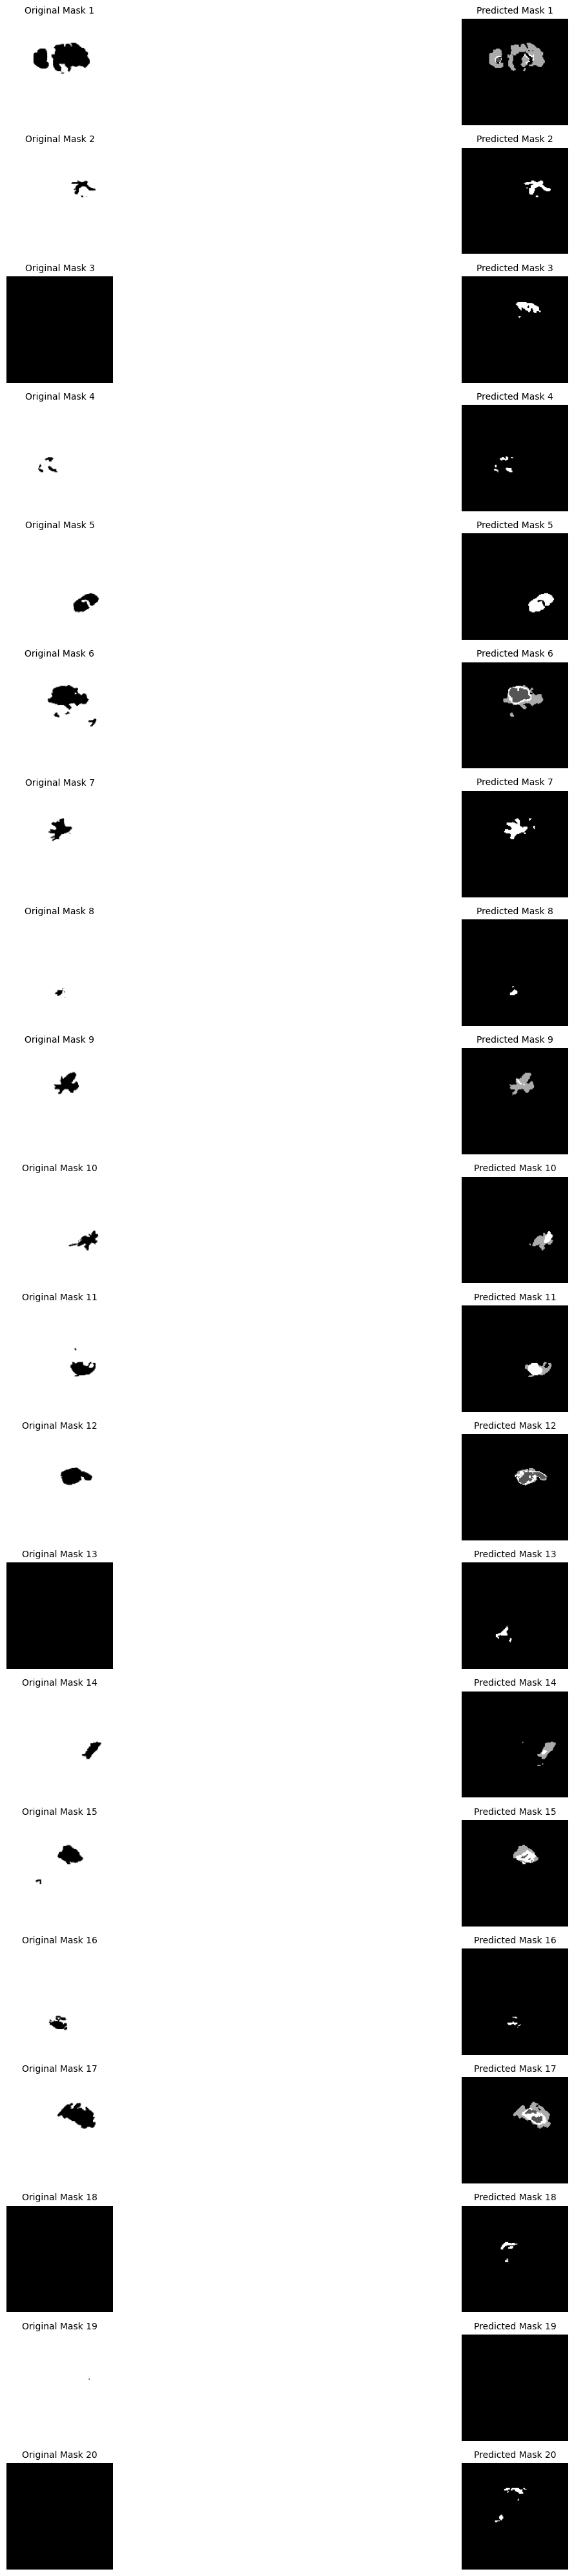

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Function to visualize the random masks and their predictions
def visualize_random_masks(generator, model, num_samples):
    # Randomly select 'num_samples' indices from the generator
    random_indices = np.random.choice(len(generator), size=num_samples, replace=False)
    
    # Adjust figure size for better layout when displaying 100 images
    plt.figure(figsize=(20, num_samples * 2))  # Adjusting the height for 100 samples
    
    for idx, random_index in enumerate(random_indices):
        # Get the batch of data for the current index
        X, Y = generator[random_index]  # X: input, Y: original mask (segmentation mask)

        # Take the first sample from the batch and the first slice
        original_mask = Y[0, :, :, 0]  # Original mask (assuming single channel output for the mask)

        # Take the first slice of the input image (e.g., 128x128 image with 2 channels)
        X_slice = X[0, :, :, :]  # Choose the first image slice from the batch

        # Generate the prediction from the model
        predicted_mask = model.predict(X_slice[None, :, :, :])[0]  # Adding the batch dimension

        # Assuming that predicted_mask is a one-hot encoded mask, we need to take the argmax to get the predicted class
        predicted_mask = np.argmax(predicted_mask, axis=-1)  # Convert to single class prediction (class with max value)

        # Plot original mask and predicted mask side by side
        ax = plt.subplot(num_samples, 2, idx * 2 + 1)
        ax.set_title(f"Original Mask {idx+1}", fontsize=10)
        ax.imshow(original_mask, cmap='gray')
        ax.axis('off')

        ax = plt.subplot(num_samples, 2, idx * 2 + 2)
        ax.set_title(f"Predicted Mask {idx+1}", fontsize=10)
        ax.imshow(predicted_mask, cmap='gray')
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# Example usage
visualize_random_masks(test_generator, model, num_samples=20)


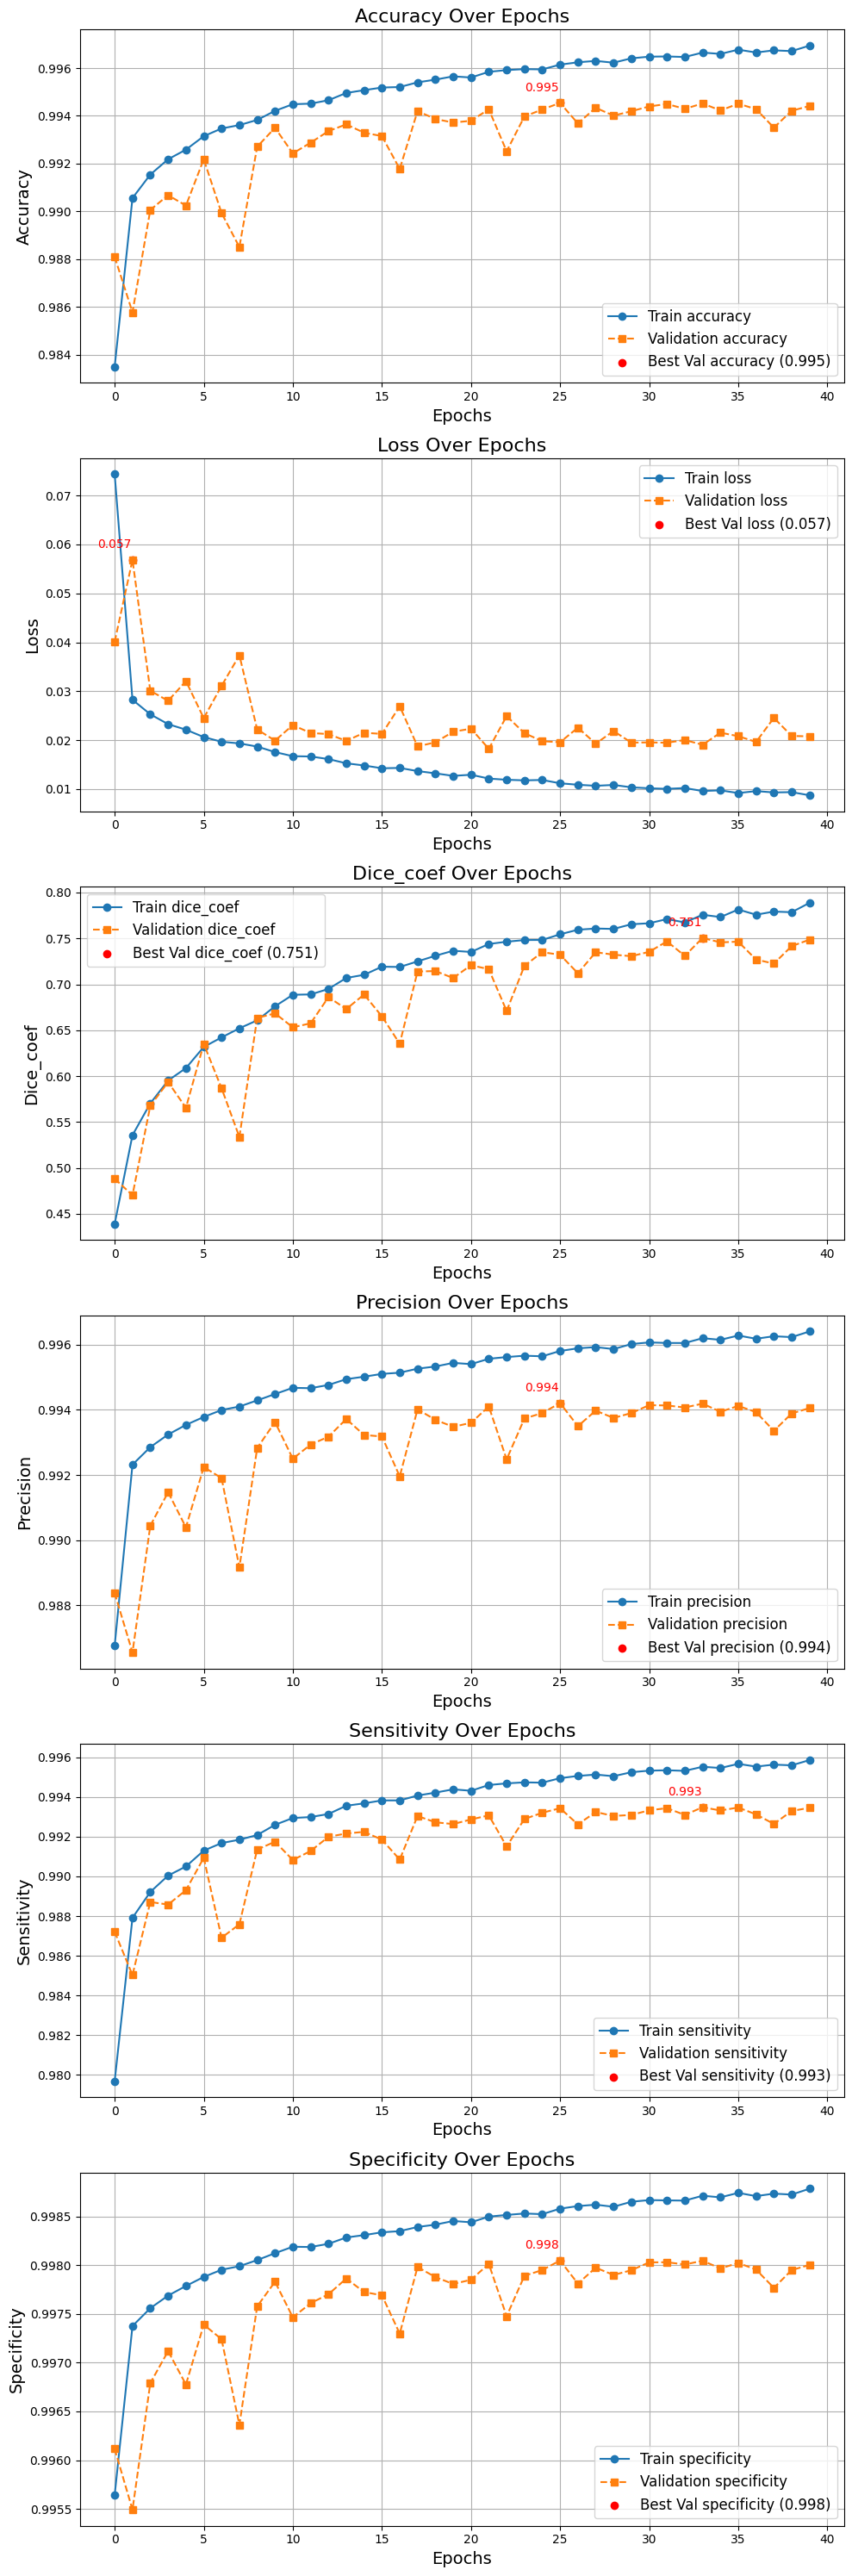

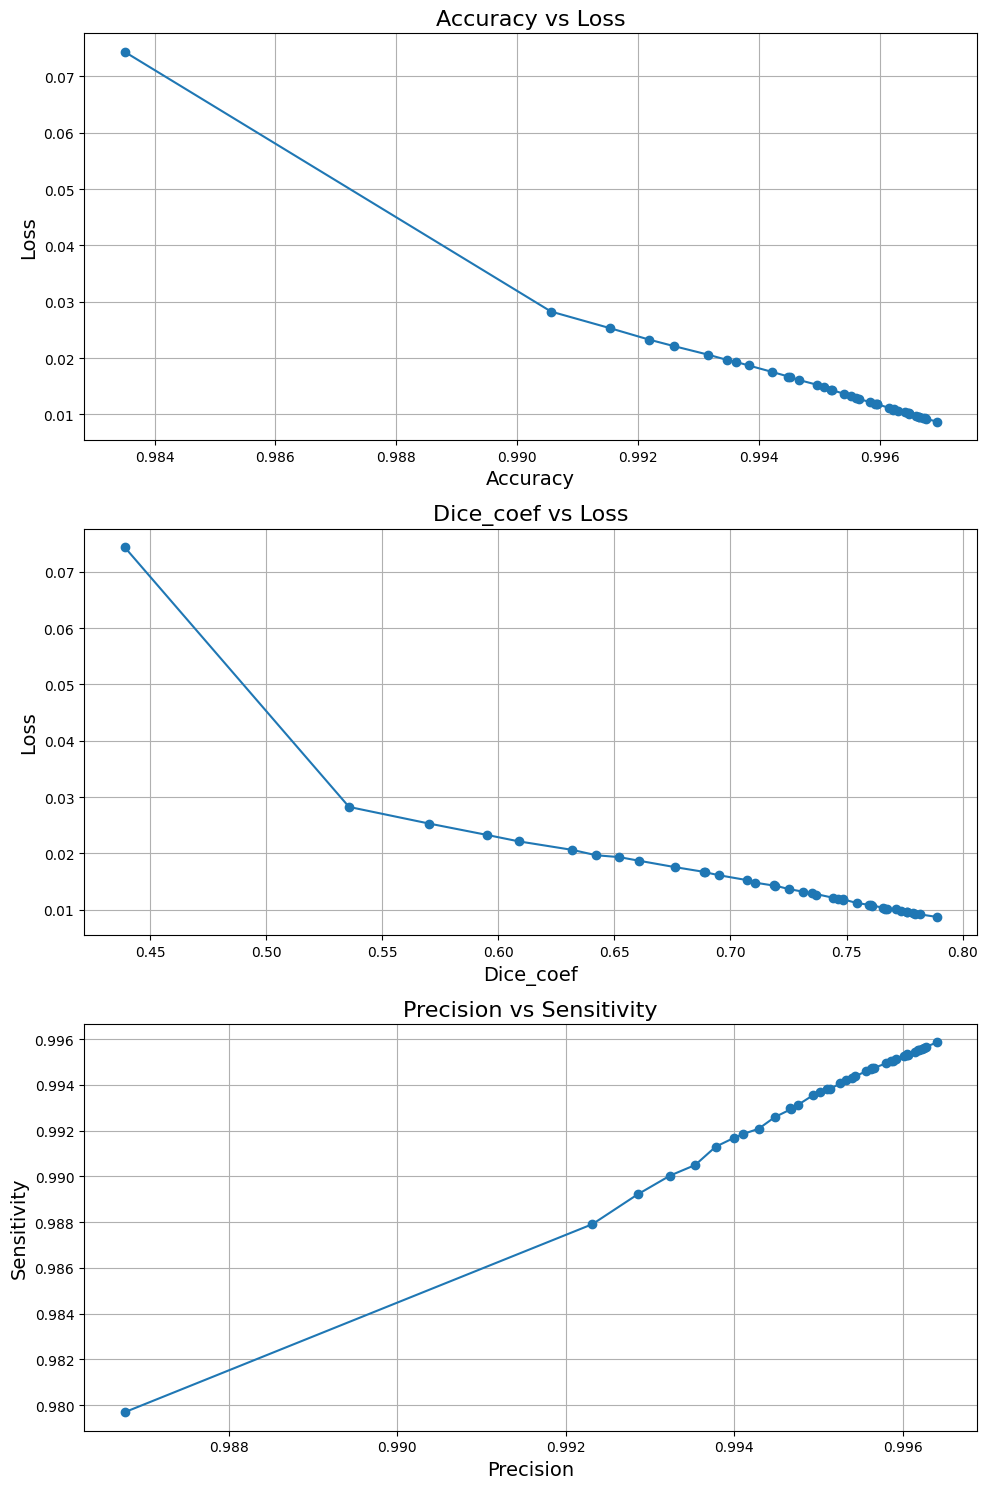

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def plot_training_history_enhanced(history, metrics):
    """
    Plots the metrics and loss over epochs from the training history with enhancements.

    :param history: The History object returned by model.fit().
    :param metrics: List of metric names to plot (e.g., ['accuracy', 'loss']).
    """
    num_metrics = len(metrics)
    fig, axes = plt.subplots(nrows=num_metrics, ncols=1, figsize=(10, 5 * num_metrics))
    if num_metrics == 1:
        axes = [axes]  # Ensure axes is iterable for a single metric
    
    for i, metric in enumerate(metrics):
        ax = axes[i]
        if metric in history.history:
            ax.plot(history.history[metric], label=f'Train {metric}', marker='o', linestyle='-')
            if f'val_{metric}' in history.history:
                ax.plot(history.history[f'val_{metric}'], label=f'Validation {metric}', marker='s', linestyle='--')
            
            # Highlight the best epoch for validation metric
            if f'val_{metric}' in history.history:
                best_epoch = np.argmax(history.history[f'val_{metric}'])
                best_value = history.history[f'val_{metric}'][best_epoch]
                ax.scatter(best_epoch, best_value, color='red', label=f'Best Val {metric} ({best_value:.3f})')
                ax.annotate(f"{best_value:.3f}", (best_epoch, best_value),
                            textcoords="offset points", xytext=(-15, 10), ha='center', fontsize=10, color='red')
        
        ax.set_title(f'{metric.capitalize()} Over Epochs', fontsize=16)
        ax.set_xlabel('Epochs', fontsize=14)
        ax.set_ylabel(metric.capitalize(), fontsize=14)
        ax.legend(fontsize=12)
        ax.grid(True)
    
    plt.tight_layout()
    plt.show()

def plot_metric_vs_metric(history, metric_pairs):
    """
    Plots one metric against another to visualize their relationship.

    :param history: The History object returned by model.fit().
    :param metric_pairs: List of tuples containing pairs of metrics to plot (e.g., [('accuracy', 'loss')]).
    """
    num_pairs = len(metric_pairs)
    fig, axes = plt.subplots(nrows=num_pairs, ncols=1, figsize=(10, 5 * num_pairs))
    if num_pairs == 1:
        axes = [axes]  # Ensure axes is iterable for a single pair
    
    for i, (metric_x, metric_y) in enumerate(metric_pairs):
        ax = axes[i]
        if metric_x in history.history and metric_y in history.history:
            ax.plot(history.history[metric_x], history.history[metric_y], marker='o', linestyle='-')
            ax.set_title(f'{metric_x.capitalize()} vs {metric_y.capitalize()}', fontsize=16)
            ax.set_xlabel(metric_x.capitalize(), fontsize=14)
            ax.set_ylabel(metric_y.capitalize(), fontsize=14)
            ax.grid(True)
    
    plt.tight_layout()
    plt.show()

# Example usage
metrics_to_plot = ['accuracy', 'loss', 'dice_coef', 'precision', 'sensitivity', 'specificity']
plot_training_history_enhanced(history, metrics_to_plot)

metric_pairs_to_plot = [('accuracy', 'loss'), ('dice_coef', 'loss'), ('precision', 'sensitivity')]
plot_metric_vs_metric(history, metric_pairs_to_plot)

